In [70]:
import numpy as np
import scipy.linalg as la
import scipy.optimize as opt
import time
import quantecon as qe
import matplotlib.pyplot as plt

from collections import namedtuple
from scipy.interpolate import interp1d, UnivariateSpline
from scipy.misc import derivative
from interpolation.complete_poly import (CompletePolynomial,
                                         n_complete, complete_polynomial,
                                         complete_polynomial_der,
                                         _complete_poly_impl,
                                         _complete_poly_impl_vec,
                                         _complete_poly_der_impl,
                                         _complete_poly_der_impl_vec)
from numba import jit, vectorize

In [71]:
#
# Create a named tuple type that we can pass into the jitted functions
# so that we don't have to pass parameters one by one
#
Params = namedtuple("Params", ["N", "beta", "g", "a_bar", "eta", "u_bar"])

@jit(nopython=True)
def param_unpack(params):
    "Unpack parameters from the Params type"
    out = (params.N, params.beta, params.g,
           params.a_bar, params.eta, params.u_bar)

    return out

In [72]:
#
# Helper functions to make sure things are jitted
#
@vectorize(nopython=True)
def u(c, eta, u_bar):
    "log utility function"
    return -1e10 if c < 1e-10 else (u_bar + np.log(c)) if eta==1 else (u_bar + (c**(1-eta)/(1-eta)))

@vectorize(nopython=True)
def du(c,eta):
    "Derivative of log utility function"
    return 1e10 if c < 1e-10 else c**(-eta)

@vectorize(nopython=True)
def duinv(u,eta):
    "Inverse of the derivative of the CRRA utility function"
    return u**(-1.0/eta )

@vectorize(nopython=True)
def f(X):
    "production function"
    return X

@vectorize(nopython=True)
def df(X):
    "Derivative of production function"
    return 1

@vectorize(nopython=True)
def discount_factor(beta, a_bar, c, w):
    "risk adjusted discount factor"
    return beta*a_bar*w/(c + a_bar*w)

@vectorize(nopython=True)
def next_x(X, N, g, c, w):
    # next period's CPR given c and w
    return (X - N*(c + w))*(1+g)

@vectorize(nopython=True)
def expendables(X, Xp, N, g):
    # get expendables given X and X prime
    return (1/N)*(X - Xp/(1 + g))

@vectorize(nopython=True)
def logu_c_from_exp(Vp, E, beta, a):
    # get expendables given X and X prime
    return -(2*E*a - 2*E*a**2 + E*a*(Vp*beta*(4*a + Vp*beta - 4))**0.5 - E*Vp*a*beta)/(2*(a**2 - 2*a + 1))

@vectorize(nopython=True)
def vector_dampen(vec1, vec2, dampen=1):
    return dampen*vec1 + (1-dampen)*vec2

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

@vectorize(nopython=True)
def psurvival(a_bar, c, w):
    return a_bar*w/(c + a_bar*w)

In [73]:
np.round(np.geomspace(3,10000,1000),3)[:100]

array([3.   , 3.024, 3.049, 3.074, 3.099, 3.124, 3.15 , 3.175, 3.201,
       3.227, 3.254, 3.28 , 3.307, 3.334, 3.361, 3.389, 3.416, 3.444,
       3.472, 3.5  , 3.529, 3.558, 3.587, 3.616, 3.645, 3.675, 3.705,
       3.735, 3.766, 3.797, 3.827, 3.859, 3.89 , 3.922, 3.954, 3.986,
       4.019, 4.051, 4.084, 4.118, 4.151, 4.185, 4.219, 4.254, 4.288,
       4.323, 4.358, 4.394, 4.43 , 4.466, 4.502, 4.539, 4.576, 4.613,
       4.651, 4.689, 4.727, 4.766, 4.805, 4.844, 4.883, 4.923, 4.963,
       5.004, 5.044, 5.086, 5.127, 5.169, 5.211, 5.253, 5.296, 5.339,
       5.383, 5.427, 5.471, 5.516, 5.561, 5.606, 5.652, 5.698, 5.744,
       5.791, 5.838, 5.886, 5.934, 5.982, 6.031, 6.08 , 6.13 , 6.18 ,
       6.23 , 6.281, 6.332, 6.384, 6.436, 6.488, 6.541, 6.595, 6.648,
       6.702])

In [74]:
class Model(object):
    """
    """
    def __init__(self, N=1, beta=0.9, g_x=0.01, g_a=0.015, a_bar=1000, 
                 eta=1, u_bar=0, 
                 xmin=3, xmax=10000, nx=1000):
        # calculate g from g_a and g_x 
        g = g_a + g_x + g_a*g_x

        # Household parameters
        self.beta, self.eta, self.u_bar, = beta, eta, u_bar

        # Firm/technology parameters
        self.N, self.g, self.a_bar = N, g, a_bar

        # Create t grids
        self.xgrid = N*np.linspace(xmin, xmax, nx)
        self.nx = nx
        
    def _unpack_params(self):
        out = (self.N, self.beta, self.g, 
               self.a_bar, self.eta, self.u_bar)
        return out

    def _unpack_grids(self):
        out = (self.xgrid)
        return out

In [75]:
class GeneralSolution:
    """
    This is a general solution method. We define this, so that we can
    sub-class it and define specific update methods for each particular
    solution method
    """
    def __init__(self, ncgm, prev_sol=None):
        # Save model, interp. approx. kind. and deriv. dx
        self.ncgm = ncgm

        # Unpack some info from ncgm
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        self.xgrid = self.ncgm.xgrid

        # Use parameter values from model to create a namedtuple with
        # parameters saved inside
        self.params = Params(N, beta, g, a_bar, eta, u_bar)
        
        self.CP = self.xgrid/N
        self.WP = np.zeros(ncgm.nx)
        self.VF = u(self.CP, eta, u_bar)
        
    def _unpack_params(self):
        return self.ncgm._unpack_params()
        
    def compute_distance(self, cp, wp, VF):
        """
        Computes distance between policy functions
        """
        return np.max([
            np.max(np.abs(1.0 - (cp+1e-15)/(self.CP+1e-15))), 
            np.max(np.abs(1.0 - (wp+1e-15)/(self.WP+1e-15))),
            np.max(np.abs(1.0 - (VF+1e-15)/(self.VF+1e-15)))
        ])
    
    def get_EV(self, x):
        idx = np.searchsorted(self.xgrid, x, side='left')
        return self.VF[idx]

    def solve(self, tol=1e-6, maxiter=2500, verbose=True, 
              nskipprint=25, dampen=1.0):
        # Iterate until convergence
        dist, it = 10.0, 0
        while (dist>tol) and (it<maxiter):
            # Run solution specific update code
            cp, wp, VF = self.update()

            # Update distance and iterations
            dist = self.compute_distance(cp, wp, VF)
            self.CP, self.WP, self.VF = cp, wp, VF
            it += 1
            if verbose and it%nskipprint == 0:
                print(it, dist)

#         # After finishing iteration, iterate to convergence using policy
#         if not isinstance(self, IterateOnPolicy):
#             sol_iop = IterateOnPolicy(self.ncgm, self)
#             cp, wp, VF = sol_iop.solve(tol=tol)
            
#             VF = vector_dampen(VF, self.VF, dampen)
            
#             # Save final versions of everything
#             self.CP, self.WP, self.VF = cp, wp, VF

        return self.CP, self.WP, self.VF
        
        

    def simulate(self, X=None, T=1000, s=1):
        """
        Simulates the neoclassical growth model with policy function
        given by self.KP. Simulates for `T` periods and discarsd first
        nburn `observations`
        """
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        # X is starting point, if None, set to N*274
        if X is None:
            X = N*274
            
        def recurse_bellman(x, t):
            if x <= 0:
                return 0, 0, x, t
            if t >= T:
                return u(x/N, eta, u_bar), 1, x, T
            
            c_corner = x/N 
            u_corner = u(c_corner, eta, u_bar)
            
            trans_idx = np.searchsorted(self.ncgm.xgrid, x, side='left')
            
            c = s*self.CP[trans_idx]
            w = s*self.CP[trans_idx]

            
            if w <= 0:
                c = c_corner 
                
            m_t = psurvival(a_bar, c, w)
            u_t = u(c, eta, u_bar)
            x_prime = next_x(x, N, g, c, w)
            
            v_prime, m_prime, final_state, nperiods = recurse_bellman(x_prime, t+1)
            
            if u_t + v_prime < u_corner:
                return u_corner, 0, 0, t+1
            
            return u_t + v_prime, m_t*m_prime, final_state, nperiods
        
        return recurse_bellman(X, 0)



In [76]:
class IterateOnPolicy(GeneralSolution):
    """
    Subclass of the general solution method. The update method for this
    class simply computes the fixed point of the value function given
    a specific policy
    """
    def compute_distance(self, cp, wp, VF):
        """
        Computes distance between policy functions. When we are
        iterating on a specific policy, we would like to compute
        distances by the difference between VFs
        """
        dist = np.max(np.abs(1.0 - (VF+1e-15)/(self.VF+1e-15)))

        return dist

    def update(self):
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        X = self.ncgm.xgrid
        
        Xn = next_x(X, N, g, self.CP, self.WP)

        # Update the value function
        EV = self.get_EV(Xn)
        VF = u(self.CP, eta, u_bar) + beta*np.maximum(EV, np.zeros(self.ncgm.nx))      

        return self.CP, self.WP, VF

In [77]:
class QRL(GeneralSolution):
    """
    Updates the coefficients and value functions using Q-Reinforcement Learning
    method
    """
    def update(self):
        """
        Updates the coefficients and value functions using the VFI_ECM
        method
        """
        # Unpack parameters
        N, beta, g, a_bar, eta, u_bar = self._unpack_params()
        xgrid = self.ncgm.xgrid
        n_state = xgrid.shape[0]

        # Get the policy and update it
        cp = np.copy(self.CP)
        wp = np.copy(self.WP)
        VF = np.copy(self.VF)
        for i_s in range(n_state):
            # Pull out current vals
            X = xgrid[i_s]
            c = cp[i_s]
            w = wp[i_s]
            v = VF[i_s]
            
            lbnd = 0
            ubnd = X*(1 + g)
            
            # get starting idx
            Xp = next_x(X, N, g, c, w)
            trans_idx_start = np.searchsorted(xgrid, Xp, side='left')
            
            # iterate up until value begins decreasing
            trans_idx = trans_idx_start
            vt = v
            while vt == v and Xp <= ubnd and trans_idx < self.ncgm.nx:  
                Xp = xgrid[trans_idx]
                Vp = self.VF[trans_idx]
                E = expendables(X, Xp, N, g)

                ct = logu_c_from_exp(Vp, E, beta, a_bar)
                # if outside of bounds break out of loop
                if ct > E or ct < 0:
                    print("ct: ", ct)
                    break
                wt = E - ct
                vt = u_bar + np.log(ct) + discount_factor(beta, a_bar, ct, wt)*Vp

                if vt > v:
                    c = ct
                    w = wt
                    v = vt
                    
                trans_idx += 1
            
            # iterate down until value begins decreasing
            
            trans_idx = trans_idx_start
            vt = v
            while vt == v and Xp > lbnd and trans_idx >= 0:       
                Xp = xgrid[trans_idx]
                Vp = self.VF[trans_idx]
                E = expendables(X, Xp, N, g)

                ct = logu_c_from_exp(Vp, E, beta, a_bar)
                # if outside of bounds break out of loop
                if ct > E or ct < 0:
                    print("ct: ", ct)
                    break
                wt = E - ct
                vt = u_bar + np.log(ct) + discount_factor(beta, a_bar, ct, wt)*Vp

                if vt > v:
                    c = ct
                    w = wt
                    v = vt
                    
                trans_idx -= 1

            cp[i_s] = c
            wp[i_s] = w
            VF[i_s] = v
            
        return cp, wp, VF

    


In [78]:
ncgm = Model(N=1, a_bar=1000, xmin=1,xmax=400, nx=2000)

# First guess
vp = IterateOnPolicy(ncgm)
vp.solve(tol=1e-9)

np.random.seed(61089)


print('vp done')
dx=1e-6
new_sol = vp
new_sol = QRL(ncgm, prev_sol=new_sol)
ts = time.time()
new_sol.solve(tol=1e-4, verbose=True, nskipprint=25)
time_took = time.time() - ts

vp done
ct:  0.02455755272416253
ct:  0.02455755272416253
ct:  0.2243571522236119
ct:  0.2243571522236119
ct:  0.4241567517230613
ct:  0.4241567517230613
ct:  0.6239563512225108
ct:  0.6239563512225108
ct:  0.8237559507219602
ct:  0.8237559507219602
ct:  1.0235555502214095
ct:  1.0235555502214095
ct:  1.223355149720859
ct:  1.223355149720859
ct:  1.4231547492203085
ct:  1.4231547492203085
ct:  1.6229543487197577
ct:  1.6229543487197577
ct:  1.8227539482192072
ct:  1.8227539482192072
ct:  2.0225535477186565
ct:  2.0225535477186565
ct:  2.222353147218106
ct:  2.222353147218106
ct:  2.4221527467175554
ct:  2.4221527467175554
ct:  2.621952346217005
ct:  2.621952346217005
ct:  2.8217519457164544
ct:  2.8217519457164544
ct:  3.021551545215904
ct:  3.021551545215904
ct:  3.221351144715353
ct:  3.221351144715353
ct:  3.4211507442148026
ct:  3.4211507442148026
ct:  3.620950343714252
ct:  3.620950343714252
ct:  3.8207499432137015
ct:  3.8207499432137015
ct:  4.020549542713151
ct:  4.020549542713

ct:  55.768645813070556
ct:  55.968445412570006
ct:  55.968445412570006
ct:  56.16824501206945
ct:  56.16824501206945
ct:  56.3680446115689
ct:  56.3680446115689
ct:  56.56784421106835
ct:  56.56784421106835
ct:  56.7676438105678
ct:  56.7676438105678
ct:  56.967443410067254
ct:  56.967443410067254
ct:  57.1672430095667
ct:  57.1672430095667
ct:  57.36704260906615
ct:  57.36704260906615
ct:  57.566842208565596
ct:  57.566842208565596
ct:  57.76664180806504
ct:  57.76664180806504
ct:  57.966441407564496
ct:  57.966441407564496
ct:  58.166241007063945
ct:  58.166241007063945
ct:  58.366040606563395
ct:  58.366040606563395
ct:  58.565840206062845
ct:  58.565840206062845
ct:  58.765639805562294
ct:  58.765639805562294
ct:  58.965439405061744
ct:  58.965439405061744
ct:  59.1652390045612
ct:  59.1652390045612
ct:  59.365038604060636
ct:  59.365038604060636
ct:  59.564838203560086
ct:  59.564838203560086
ct:  59.764637803059536
ct:  59.764637803059536
ct:  59.964437402558985
ct:  59.96443740

ct:  200.62335545017135
ct:  200.82315504967082
ct:  200.82315504967082
ct:  201.02295464917026
ct:  201.02295464917026
ct:  201.22275424866976
ct:  201.22275424866976
ct:  201.42255384816917
ct:  201.42255384816917
ct:  201.62235344766862
ct:  201.62235344766862
ct:  201.82215304716806
ct:  201.82215304716806
ct:  202.02195264666753
ct:  202.02195264666753
ct:  202.22175224616697
ct:  202.22175224616697
ct:  202.42155184566641
ct:  202.42155184566641
ct:  202.62135144516586
ct:  202.62135144516586
ct:  202.8211510446653
ct:  202.8211510446653
ct:  203.02095064416477
ct:  203.02095064416477
ct:  203.2207502436642
ct:  203.2207502436642
ct:  203.42054984316363
ct:  203.42054984316363
ct:  203.6203494426631
ct:  203.6203494426631
ct:  203.82014904216257
ct:  203.82014904216257
ct:  204.019948641662
ct:  204.019948641662
ct:  204.21974824116143
ct:  204.21974824116143
ct:  204.4195478406609
ct:  204.4195478406609
ct:  204.61934744016037
ct:  204.61934744016037
ct:  204.81914703965978
ct: 

ct:  343.87966829127663
ct:  344.0794678907761
ct:  344.0794678907761
ct:  344.2792674902755
ct:  344.2792674902755
ct:  344.4790670897749
ct:  344.4790670897749
ct:  344.67886668927446
ct:  344.67886668927446
ct:  344.87866628877384
ct:  344.87866628877384
ct:  345.0784658882734
ct:  345.0784658882734
ct:  345.2782654877728
ct:  345.2782654877728
ct:  345.4780650872722
ct:  345.4780650872722
ct:  345.6778646867717
ct:  345.6778646867717
ct:  345.8776642862711
ct:  345.8776642862711
ct:  346.07746388577056
ct:  346.07746388577056
ct:  346.27726348527
ct:  346.27726348527
ct:  346.4770630847695
ct:  346.4770630847695
ct:  346.67686268426894
ct:  346.67686268426894
ct:  346.87666228376844
ct:  346.87666228376844
ct:  347.0764618832678
ct:  347.0764618832678
ct:  347.27626148276727
ct:  347.27626148276727
ct:  347.4760610822667
ct:  347.4760610822667
ct:  347.67586068176615
ct:  347.67586068176615
ct:  347.87566028126554
ct:  347.87566028126554
ct:  348.07545988076504
ct:  348.07545988076

In [79]:
# new_sol.simulate(274,500,s=0.1)

(31.59885721488171, 0.0, 0, 17)

In [80]:
new_sol.xgrid

array([  1.       ,   1.1995998,   1.3991996, ..., 399.6008004,
       399.8004002, 400.       ])

In [81]:
new_sol.CP

array([  1.       ,   1.1995998,   1.3991996, ..., 399.6008004,
       399.8004002, 400.       ])

In [82]:
new_sol.WP

array([0., 0., 0., ..., 0., 0., 0.])

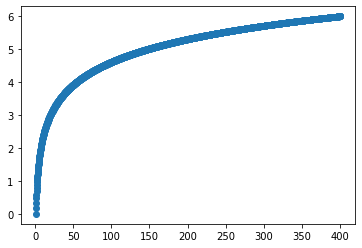

In [83]:
X = new_sol.xgrid
xmax = 200000
xnew = np.arange(1,xmax,1)
max_idx = np.argmax(X[X < xmax]) + 1


plt.plot(X[:max_idx], new_sol.VF[:max_idx], 'o')

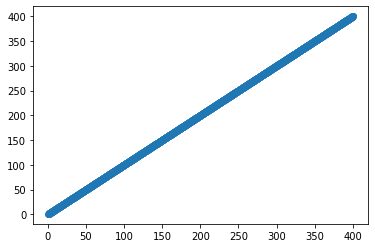

In [84]:
plt.plot(X[:max_idx], new_sol.CP[:max_idx], 'o')

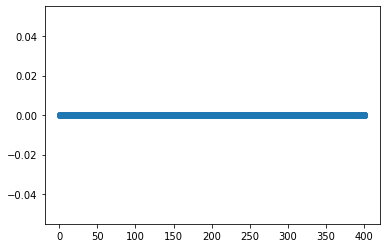

In [85]:
plt.plot(X[:max_idx], new_sol.WP[:max_idx], 'o')